<a id='contents'><h1>Quantifying spotting patterns</h1></a>

*M. cupreus* x *M. luteus* var. *variegatus* hybrid flowers often develop really interesting speckling patterns on their flower petals. Let's try to quantify some traits of this. 

There are still a lot of issues with the process of digitizing polygons, many are not creating correctly. But here we'll forge ahead and draw up a pipeline for analyzing the polygons that are digitizing without problems. 

Some of this code is from the early days, when I tried to stay in matlab. I have kept it here where it is illustrative. The rest is in python. 

<h3>Contents</h3>

[Examples of why this is hard:](#hard)  
  - [Concave polygons](#concave)
  - [Edge polygons](#edge)  
  
[Overview: the spot traits](#traits)

<h2><a id='hard'>Why this is hard</a></h2>

Describing complex spatial patterns by flattening them into simple statistics is almost always difficult. Information loss is inevitable. 

Just as one example: one of the statistics we are interested in is a simple statistic for quantifying centeredness - for instance, average distance of polygon centroids from the centroid of the entire petal. However, some issues arise...

<a id="concave"><h4>Concave polygons</h4></a>

Centroids used in this way can be misleading for some polygons, such as polygons that follow the exteriour line of the petal. Often, with these the centroid is outside of the polygon itself and not really representative the bulk of the area within that polygon, in terms of centeredness:

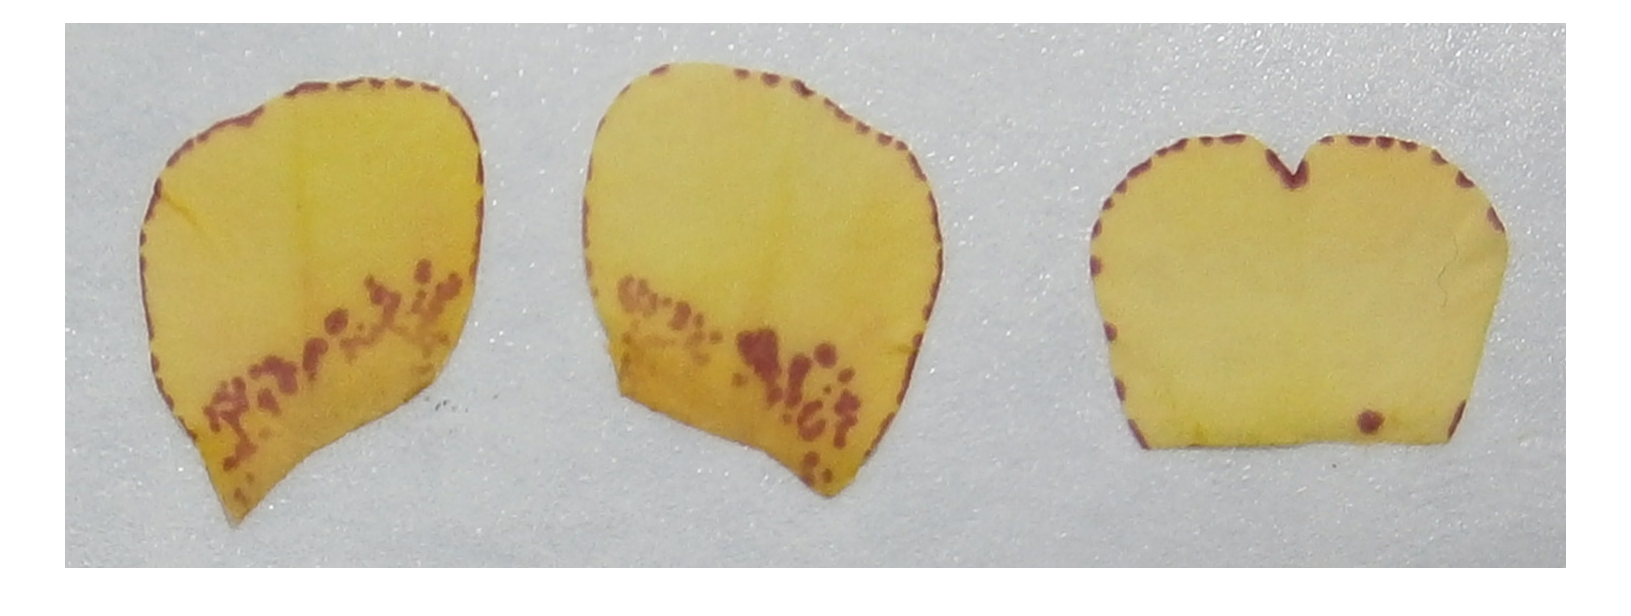

In [42]:
P371F2 = (objDir + "P371F2" + ".mat");
P371F2 = load(P371F2);
[a,b,c] = fileparts(P371F2.Petals.fullName);
jpegName = char(dougDir + b + c);
imshow(jpegName);

In [39]:
petal = P371F2.Petals.Polys.right.petal;
spot = P371F2.Petals.Polys.right.spots(1);
[cX, cY] = centroid(spot);
[CX, CY] = centroid(petal);

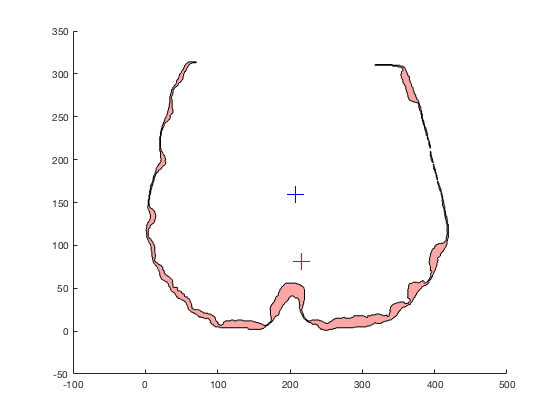

In [40]:
plot(spot, 'FaceColor','red');
hold on
plot(cX, cY, '+', 'MarkerSize', 15, 'Color', 'red');
plot(CX, CY, '+', 'MarkerSize', 15, 'Color', 'blue');
hold off

The blue cross represents the petal centroid, the red is the centroid of this ring-like polygon. This flower scores relatively high on our centeredness metric, because this major spot is concave, causing its center of gravity to be outside its polgyon borders, and because it is ~radially symmetric around the center. So its centroid falls close to the center of the petal. But this polygon is the exact opposite of centered - its spots exist as far from the center as they can!

Granted, this polygon happened because of errors in our digitization algorithms, and is actually many small spots on the real flower. But long, thin, edge-following spots aren't uncommon in the actual petals. And perhaps we can use this opportunity to account partially for the errors of digitization. 

Side note, if digitization had gone well, each of these spots' centroids would lie far from the center of the petal, and these numerous long distances would would overwhelm any centered spots of interest (discussed next). 

<a id='edge'><h4>Edge polygons</h4></a>

Related to the above, spots on the rim of the petal often cooccur with the centered spots that we are trying to detect. For instance, for the flower P378F2 has a really cool, somewhat centered spot on it's ventral petal that we'd like to score with our algorithm: 

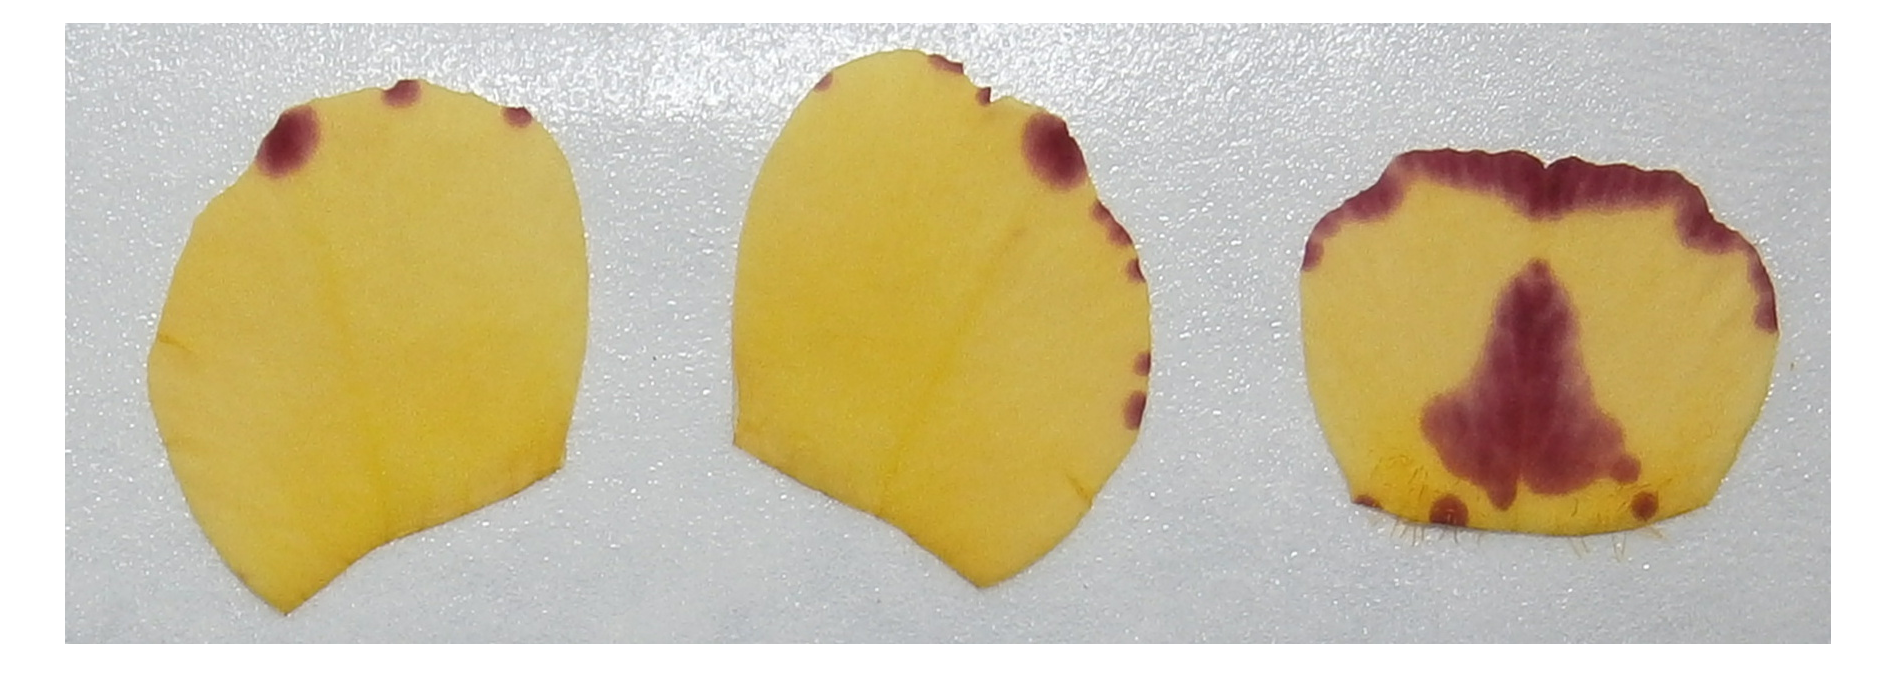

In [14]:
P378F2 = (objDir + "P378F2" + ".mat");
P378F2 = load(P378F2);
[a,b,c] = fileparts(P378F2.Petals.fullName);
jpegName = char(dougDir + b + c);
imshow(jpegName);

But it also has basal spots that are probably extensions of the nectar guides, and and a long, thin rim spot on the distal end of the petal. Both of these spots are interesting, and we hope to examine them a little using a "edginess" statistic. But we don't want them to bias our search for higly centered spots. 

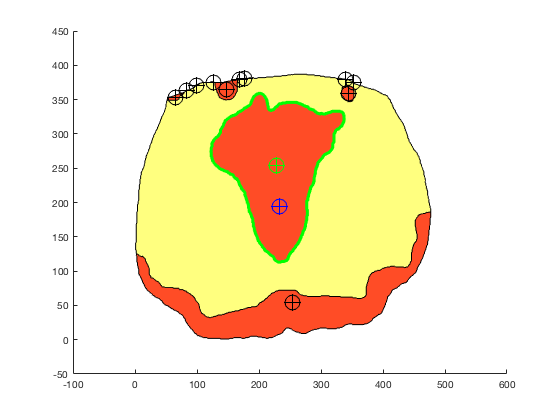

In [15]:
petal = P378F2.Petals.Polys.right.petal;
spot = P378F2.Petals.Polys.right.spots(3);
spots = P378F2.Petals.Polys.right.spots;

%% petal graphic:
plot(petal, "FaceColor","yellow", "FaceAlpha",0.5)
hold on;
plot(spots, "FaceColor","red","FaceAlpha",0.7)
plot(spot, "FaceColor","white","FaceAlpha",0, "EdgeColor",'green','Linewidth',3)

[CX, CY] = centroid(petal);
[cX, cY] = centroid(spot);
[csX, csY] = centroid(spots);

plot(CX, CY, 'o', 'MarkerSize', 15, 'Color', 'blue');
plot(CX, CY, '+', 'MarkerSize', 15, 'Color', 'blue');
plot(csX, csY, 'o', 'MarkerSize', 15, 'Color', 'black');
plot(csX, csY, '+', 'MarkerSize', 15, 'Color', 'black');
plot(cX, cY, 'o', 'MarkerSize', 15, 'Color', 'green');
plot(cX, cY, '+', 'MarkerSize', 15, 'Color', 'green');

The blue point is our petal centroid. The green point is the centroid of just our non-edge spot (green outline), possibly the only polygon we care about in the petal for this statistic. The black centroids are the edge-associated spots' centroids. If we don't correct for rim spots, these distances will quickly outweigh the relatively centered non-edge spot of interest.

Etc. Etc. Spatial analysis is hard. So what are we gonna do about it? For each trait, we'll try describing a couple different ways. At this point the spot digitization and zone algorithms fail a lot, so for each trait we'll start with crude but robust ways of looking at a trait, and increase the precision in degrees from there. 

So for right now there are several statistics describing each trait. Only the crudest (percent red in a zone, etc) will probably tell us much right now, until we can clean up the data to handle the more precise traits (spot centroids, number of spots, etc). 

<h2><a id='setup'>Python setup</a>

In [16]:
import os, json
import numpy as np
import shapely.geometry as sg
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd
from descartes import PolygonPatch

In [17]:
wd = '/home/daniel/Documents/mimulusSpeckling/make_polygons' ## for my laptop
os.chdir(wd)

<h2><a id='theData'>The Inputs - geojson files and FlowerPetal classes</a></h2>

The outputs of our [digitizing process](https://nbviewer.jupyter.org/github/danchurch/mimulusSpeckling/blob/master/make_polygons/petals_to_polygons.ipynb) are [geojson](http://geojson.org/) files. Each geojson file contains slots for five geometries: petal outline ("petal"), spots, center, edge, throat. All of these except for spots should be polygon objects. Spots should be a collection of polygons. Some of the outputs vary from this because of errors - we'll have to deal with this in our processing. 

All of these geojsons are scaled to a unitless area of 1.00, and are centered on the origin (0,0). 

These geojsons can then be converted into a special python object class I've made, called FlowerPetals. All of the calculations below are methods (or builtin functions) of this class. We'll load one geojson as an instance of FlowerPetal here for our plotting examples:

In [28]:
## this module not not in my python path, cuz I made them and kept it in the working directory:
from FlowerPetal import FlowerPetal
## get a flower. Path will change. 
geojsonName = "polygons/P297F2/right/P297F2_right_polys.geojson"

flP = FlowerPetal()
flP.flowerName = 'P297F2'
flP.petalName = 'right'

## assign the geojson filename:

flP.geojson = geojsonName

## read the geojson, turn it into Shapely polygons 

flP.parseGeoJson(flP.geojson)

## check for errors, try to clean them up:
flP.cleanFlowerPetal()

## run all the statistical calculations and fill in out flower attributes with this info
flP.fillColumns()


Polygon is not valid...buffering...
Returning shiny new (multi)polygon.
Polygon is not valid...buffering...
Returning shiny new (multi)polygon.
Polygon is ok! Returning it as is.
Polygon is not valid...buffering...
Returning shiny new (multi)polygon.
Polygon is ok! Returning it as is.


Calling the `flP.fillColumns()` makes the FlowerPetal try to fill out its own statistics:

In [44]:
vars(flP)

{'avgDist2CenterAllSpots': 0.4382465145952523,
 'avgDist2CenterCenterSpots': 0.2702484065248026,
 'avgDistSpotCentroid2Edge': 0.12408512415494992,
 'avgDistSpotEdge2Edge': 0.02731543671643886,
 'avgSpotSize': 0.03818332652544326,
 'biggestSpotArea': 0.1172227121674941,
 'center': <shapely.geometry.polygon.Polygon at 0x7f10c7c17ac8>,
 'centerCoveredbySpots': 0.26001529495520054,
 'distCoveredbySpots': 0.23625528497790077,
 'edge': <shapely.geometry.polygon.Polygon at 0x7f10c7c1b208>,
 'edgeCoveredbySpots': 0.26011442196317686,
 'flowerName': 'P297F2',
 'geojson': 'polygons/P297F2/right/P297F2_right_polys.geojson',
 'medSpotSize': 0.016905654850000451,
 'nuDistSpots': 2,
 'nuProxSpots': 6,
 'nuQuadIIISpots': 1,
 'nuQuadIISpots': 2,
 'nuQuadISpots': 4,
 'nuQuadIVSpots': 0,
 'nuSpotCentroidsInCenter': 2,
 'nuSpots': 7,
 'nuSpotsContainedInCenter': 0,
 'nuSpotsContainedInEdge': 2,
 'nuSpotsMostlyInCenter': 2,
 'nuSpotsMostlyInEdge': 3,
 'nuSpotsMostlyInThroat': 2,
 'nuSpotsTouchActualEdge':

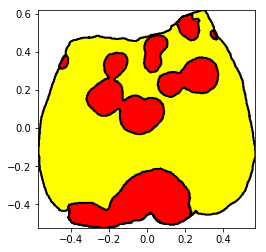

In [29]:
flP.plotOne(flP.petal); flP.addOne(flP.spots)

<h2><a id='traits'>Overview: the spot traits. And some caveats.</a></h2>

Right now there has been almost no manual curation or sanity-checking of the digitized spot images. This is an important next step now that a pipeline is in place from raw image to statistics. I will be adding a quick manual correction step into zone-creation step. As is, throat and edge zone creation fails or yield incorrect edges/throat zones often, So statistics from these should be used with care, until curation happens. If in doubt, check how a flower digitized using the [current report on these images](https://drive.google.com/open?id=1Rf08E73EmAqfIeWKPaJQAMR6nwoq_Qaf). 

Also hopefully someone will find time to correct the spots that melted into each other, etc. This can be done with QGIS on the geojson files. When I get the chance I will dive back into the early processing of the photos and see if the pixel color picking process can be tweaked a little to help. 

Also note that the digitizing and analysis/statistic-creation modules are still very new and their code needs a lot of work, especially in terms of error-handling and logging. 

So all caveats asides, here is how the statistics are generated. Most of these statistics are classic geometric operations using the [Shapely](https://shapely.readthedocs.io/en/latest/manual.html#introduction) package in python. Example code bits and/or graphics are included where I think it may be helpful for understanding. 

[<h3>General polygon:</h3>](#GP)

explanation | name of trait in code/data
------------|---------------------------
Biggest spot | [biggestSpotArea](#biggestSpotArea)
Smallest spot (is this useful at all?) | [smallestSpotArea](#smallestSpotArea)
Avg size | [avgSpotsize](#avgSpotsize)
Median size | [medSpotsize](#medSpotsize)
Number of spots | [nuSpots](#nuSpots)

[<h3>Centeredness:</h3>](#centerStats)

explanation | name of trait in code/data
------------|---------------------------
Number of spots entirely contained in center zone | [nuSpotsContainedInCenter](#nuSpotsContainedInCenter)
Number of spots touching center zone | [nuSpotsTouchCenter](#nuSpotsTouchCenter)
Number of spots mostly in center zone | [nuSpotsMostlyInCenter](#nuSpotsMostlyInCenter)
Number of spot centroids in center zone |  [nuSpotCentroidsInCenter](#nuSpotCentroidsInCenter)
avg spot centroid distance to center of all spots | [avgDist2CenterAllSpots](#avgDist2CenterAllSpots)
avg spot centroid distance to center of spots in center zone (excludes edge spots) | [avgDist2CenterCenterSpots](#avgDist2CenterCenterSpots)
Percent of total spot area in center | [propSpotsInCenter](#propSpotsInCenter)
Percent of center zone covered by spots | [centerCoveredbySpots](#centerCoveredbySpots)
Spot on centroid | [spotOnCentroid](#spotOnCentroid)

[<h3>Edgeness:</h3>](#edgeStats)

explanation | name of trait in code/data
------------|---------------------------
Number of spots entirely contained in edge zone | [nuSpotsContainedInEdge](#nuSpotsContainedInEdge)
Number of spots touching edge zone in some way | [nuSpotsTouchEdge](#nuSpotsTouchEdge)
Percent of total spot area in edge | [propSpotsInEdge](#propSpotsInEdge)
Number of spots mostly in edge zone (>Percent of) | [nuSpotsMostlyInEdge](#nuSpotsMostlyInEdge)
Percent of edge zone covered | [edgeCoveredbySpots](#edgeCoveredbySpots)
Number of spots touching actual edge (not zone)  | [nuSpotsTouchActualEdge](#nuSpotsTouchActualEdge)
Percent of length of real petal edge (not zone) covered | [realEdgeSpotted](#realEdgeSpotted)
avg dist of outline of spots to edge | [avgDistSpotEdgeEdge](#avgDistSpotEdgeEdge)
avg dist of centroid of spots to edge | [avgDistSpotCentroid2Edge](#avgDistSpotCentroid2Edge)

These last two exclude spots that contact the basal cut on the petal, if possible and measure the distance to the actual edge of the petal, not the zone.

<h3>Throat:</h3>

explanation | name of trait in code/data
------------|---------------------------
Percent of throat zone covered | [throatCoveredbySpots](#throatCoveredbySpots)
Percent of total spot area in throat | [propSpotsInthroat](#propSpotsInthroat)
Number of spots touching throat zone | [nuSpotsTouchThroat](#nuSpotsTouchThroat)
Number of spots mostly in throat zone | [nuSpotsMostlyInThroat](#nuSpotsMostlyInThroat)
Number of spots touching actual cut/base | [nuSpotsTouchCut](#nuSpotsTouchCut)

<h3>Regions of petal, by distal/proximal half, or quadrant.</h3>

This is a pretty crude division of the petals into quadrants. The quadrants of the petal are designated based on the centroid and the bounding box sides as othogonal bases. The quadrants are not necesarily equal in size. Probably very rarely, actually.

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in proximal half (quadrants I and II) | [nuProxSpots](#nuProxSpots)
Percent of total spot area in proximal half (quadrants I and II) | [propSpotsInProx](#propSpotsInProx)
Percent of proximal half covered by spots (quadrants I and II) | [proxCoveredbySpots](#proxCoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in Distal half (quadrants III and IV) | [nuDistSpots](#nuDistSpots)
Percent of total spot area in Distal half (quadrants III and IV) | [propSpotsInDist](#propSpotsInDist)
Percent of Distal half covered by spots (quadrants III and IV) | [distCoveredbySpots](#distCoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in quadrant I | [nuQuadISpots](#nuQuadISpots)
Percent of total spot area in quadrant I | [propSpotsInQuadI](#propSpotsInQuadI)
Percent of quadrant I covered by spots | [quadICoveredbySpots](#quadICoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in quadrant II | [nuQuadIISpots](#nuQuadIISpots)
Percent of total spot area in quadrant II | [propSpotsInQuadII](#propSpotsInQuadII)
Percent of quadrant II covered by spots | [quadIICoveredbySpots](#quadIICoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in quadrant III | [nuQuadIIISpots](#nuQuadIIISpots)
Percent of total spot area in quadrant III | [quadIIISpotsInQuadIII](#quadIIISpotsInQuadIII)
Percent of quadrant III covered by spots | [quadIIICoveredbySpots](#quadIIICoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in quadrant IV | [nuQuadIVSpots](#nuQuadIVSpots)
Percent of total spot area in quadrant IV | [propSpotsInQuadIV](#propSpotsInQuadIV)
Percent of quadrant IV covered by spots | [quadIVCoveredbySpots](#quadIVCoveredbySpots)



<h3><a id='GP'>General polygon statistics:</a></h3>

These are pretty much self-explanatory. 

<a id='biggestSpotArea'>biggestSpotArea</a>

We take the area of largest spot polygon detected:

`biggestSpotArea = max([ i.area for i in self.spots ])`

<a id='smallestSpotArea'>smallestSpotArea</a>

We take the area of smallest spot polygon detected. Seems probably useless, but it's easy to do:

`smallestSpotArea = min([ i.area for i in self.spots ])`

<a id='avgSpotsize'>avgSpotsize</a>

We take the mean area of all spot polygons detected:

`avgSpotSize = mean([ i.area for i in self.spots ])`

<a id='medSpotsize'>medSpotsize</a>

We take the median value of all spot polygon areas detected:

`medSpotSize = np.median([ i.area for i in self.spots ])`

<a id='nuSpots'>nuSpots</a>

This is the total number of distinct spots detected:

` nuSpots = len([ i.area for i in self.spots ])`

<h3><a id='centerStats'>Centeredness:</a></h3>

In our digitizing pipeline we define a center zone that occupies the center 50% of the petal (translucent white zone) and a centroid of the petal that we consider the true center of the petal (blue plus sign): 

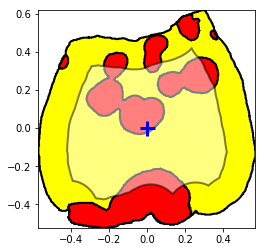

In [41]:
flP.plotOne(flP.petal); 
flP.addOne(flP.spots);
flP.addOne(flP.center, col='white', a=0.5)
plt.plot(flP.petal.centroid.x,flP.petal.centroid.y, 'b+', markersize=15, mew = 3)

<a id='nuSpotsContainedInCenter'>nuSpotsContainedInCenter</a>

This reports the number of spots contained entirely within the center zone, with no part of any of the candidate spots containing pixels outside of the center zone. This is a picky statistic, in this example petal no polygons make the cut, because the interior spots have merged with outside spots:

`nuSpotsContainedInCenter = sum([ i.within(self.center) for i in self.spots ])`

In [46]:
flP.nuSpotsContainedInCenter

0

<a id='nuSpotsTouchCenter'>nuSpotsTouchCenter</a>

Reports the number of spot polygons that have any contact at all with the center zone. This is the least picky center statistic.

`nuSpotsTouchCenter = sum([ i.intersects(self.center) for i in self.spots ])`

In [47]:
flP.nuSpotsTouchCenter

4

<a id='nuSpotsMostlyInCenter'>nuSpotsMostlyInCenter</a>

This reports the number of spot polygons that have at least 50% of their area in the center zone:

`spotsMostlyInCenter = [ i for i in self.spots if (i.intersection(self.center).area / i.area > 0.5) ]`

`nuSpotsMostlyInCenter = len(spotsMostlyInCenter)`

In [48]:
flP.nuSpotsMostlyInCenter

2

<a id='nuSpotCentroidsInCenter'>nuSpotCentroidsInCenter</a>

In addition the general petal centroid, the spot polygons each have their own centroid. This statistic reports if this centroid is within the center zone.

`nuSpotCentroidsInCenter = sum([ i.centroid.intersects(self.center) for i in self.spots ] )`

In [49]:
flP.nuSpotCentroidsInCenter

2

<a id='avgDist2CenterAllSpots'>avgDist2CenterAllSpots</a>

This calculates the average distance between centroids of our spots to our petal centroid. This includes all of our spots, and the next statistic [avgDist2CenterCenterSpots](#avgDist2CenterCenterSpots) excludes spots not in the center zone. 

`avgDist2CenterAllSpots = mean([ i.centroid.distance(self.center.centroid) for i in self.spots ])`

In [50]:
flP.avgDist2CenterAllSpots

0.4382465145952523

<a id='avgDist2CenterCenterSpots'>avgDist2CenterCenterSpots</a>

This is the same as [avgDist2CenterAllSpots](#avgDist2CenterAllSpots), but only considers spots within the center zone. This was done to make possible the search for highly centered petal spots even when numerous spots exist on the edge of a petal.

`spotsMostlyInCenter = [ i for i in self.spots if (i.intersection(self.center).area / i.area > 0.5) ]`
`avgDist2CenterCenterSpots = mean([ i.centroid.distance(self.center.centroid) for i in spotsMostlyInCenter ])`

In [51]:
flP.avgDist2CenterCenterSpots

0.2702484065248026

<a id='propSpotsInCenter'>propSpotsInCenter</a>

This reports the percentage of total spotted area to be found in the center zone. This is meant to be more robust than simple counts of polygons, against merging errors in the spots. This should be equivalent to asking how many of our red pixels are found in the center zone of the petal. 

`partSpotsInCenter = [ i.intersection(self.center) for i in self.spots if i.intersects(self.center) ]`

`propSpotsInCenter = partSpotsInCenter.area / self.spots.area`

In [52]:
flP.propSpotsInCenter

0.48402551836730245

<a id='centerCoveredbySpots'>centerCoveredbySpots</a>

This is similar to [propSpotsInCenter](#propSpotsInCenter), but reports the percentage of the center zone occupied by red pixels.

`partSpotsInCenter = [ i.intersection(self.center) for i in self.spots if i.intersects(self.center) ]`

`centerCoveredbySpots = partSpotsInCenter.area / self.center.area`

<a id='spotOnCentroid'>spotOnCentroid</a>

This simply reports whether any spot polygons are sitting on our petal centroid. True/False.

`spotOnCentroid = any([ i.intersects(self.petal.centroid) for i in self.spots ])`

<h3><a id='edgeStats'>Edgeness:</a></h3>

In our digitizing pipeline we define an center zone that occupies the center 50% of the petal. The remaining inner margin that contains the other 50% is then divided into an outer "edge" zone that buffers the natural edge of the petal, and an inner "throat" zone, that buffers the line of separation ("cut") of the petal from its flower. 

Here the edge is the translucent white zone: 

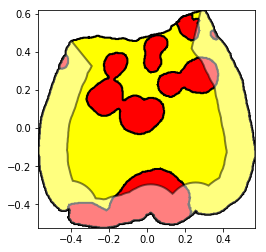

In [54]:
flP.plotOne(flP.petal); 
flP.addOne(flP.spots);
flP.addOne(flP.edge, col='white', a=0.5)

<a id='nuSpotsContainedInEdge'>nuSpotsContainedInEdge</a>



<a id='nuSpotsTouchEdge'>nuSpotsTouchEdge</a>

<a id='propSpotsInEdge'>propSpotsInEdge</a>

<a id='nuSpotsMostlyInEdge'>nuSpotsMostlyInEdge</a>

<a id='edgeCoveredbySpots'>edgeCoveredbySpots</a>

<a id='nuSpotsTouchActualEdge'>nuSpotsTouchActualEdge</a>

<a id='realEdgeSpotted'>realEdgeSpotted</a>

<a id='avgDistSpotEdgeEdge'>avgDistSpotEdgeEdge</a>

<a id='avgDistSpotCentroid2Edge'>avgDistSpotCentroid2Edge</a>

<a id='throatCoveredbySpots'>throatCoveredbySpots</a>

<a id='propSpotsInthroat'>propSpotsInthroat</a>

<a id='nuSpotsTouchThroat'>nuSpotsTouchThroat</a>

<a id='nuSpotsMostlyInThroat'>nuSpotsMostlyInThroat</a>

<a id='nuSpotsTouchCut'>nuSpotsTouchCut</a>

<a id='nuProxSpots'>nuProxSpots</a>

<a id='propSpotsInProx'>propSpotsInProx</a>

<a id='proxCoveredbySpots'>proxCoveredbySpots</a>

<a id='nuDistSpots'>nuDistSpots</a>

<a id='propSpotsInDist'>propSpotsInDist</a>

<a id='distCoveredbySpots'>distCoveredbySpots</a>

<a id='nuQuadISpots'>nuQuadISpots</a>

<a id='propSpotsInQuadI'>propSpotsInQuadI</a>

<a id='quadICoveredbySpots'>quadICoveredbySpots</a>

<a id='nuQuadIISpots'>nuQuadIISpots</a>

<a id='propSpotsInQuadII'>propSpotsInQuadII</a>

<a id='quadIICoveredbySpots'>quadIICoveredbySpots</a>

<h2><a id='wrangling'>Data wrangling - the FlowerPetal class</a></h2>

So we have a bunch of ideas for algorithms/statistics to characterize some of what is happening with these spots. There are lots of traits, and lots of flower petals. How can we collect and present these data intelligently? By creating an object class, "FlowerPetal" that can rapidly calculate these with its methods and store all of these statistics as its attributes. 

We'll call this class of objects "FlowerPetals." They are defined in the module "FlowerPetal.py", stored in the [github repo for this project](https://github.com/danchurch/mimulusSpeckling/blob/master/make_polygons/FlowerPetal.py).